<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Check whether GPU is available

In [78]:
# import torch
# torch.cuda.is_available()

Load data from prepared local csv file

In [79]:
from darts import TimeSeries
import pandas as pd


In [80]:
series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

Prepare train and validation splits

In [81]:
train, val = series.split_before(pd.Timestamp('2023-05-25'))


In [82]:
len(train), len(val)

(9705, 160)

In [83]:
train.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06027413]],

       [[0.06242664]],

       [[0.0635035 ]],

       [[0.0618885 ]],

       [[0.06081225]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 1986-03-19
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [84]:
train_df = train.pd_dataframe()


In [85]:
train_df.shape[0] - train_df.dropna().shape[0]

0

In [86]:
val.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[324.57266235]],

       [[331.51385498]],

       [[330.67732239]],

       [[329.84078979]],

       [[327.03244019]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-25 2023-05-26 ... 2023-05-31
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [87]:
val_df = val.pd_dataframe()
val_df

component,Close
Date,
2023-05-25,324.572662
2023-05-26,331.513855
2023-05-29,330.677322
2023-05-30,329.840790
2023-05-31,327.032440
...,...
2023-12-28,375.279999
2023-12-29,376.040009
2024-01-01,373.455002


In [88]:
val_df.shape[0] - val_df.dropna().shape[0]

0

Plot data splits

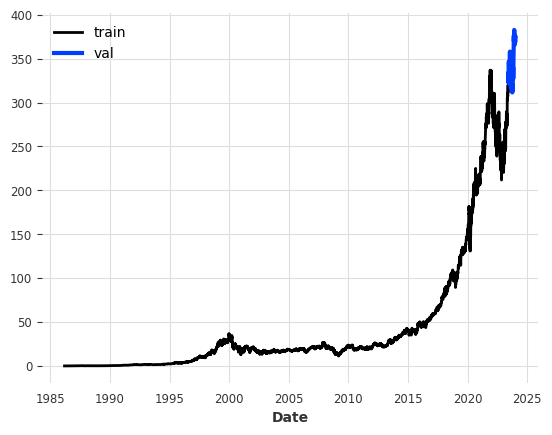

In [89]:
import matplotlib.pyplot as plt
 
train.plot(label='train')
val.plot(label='val', lw=3)
plt.legend()

Show seasonalities

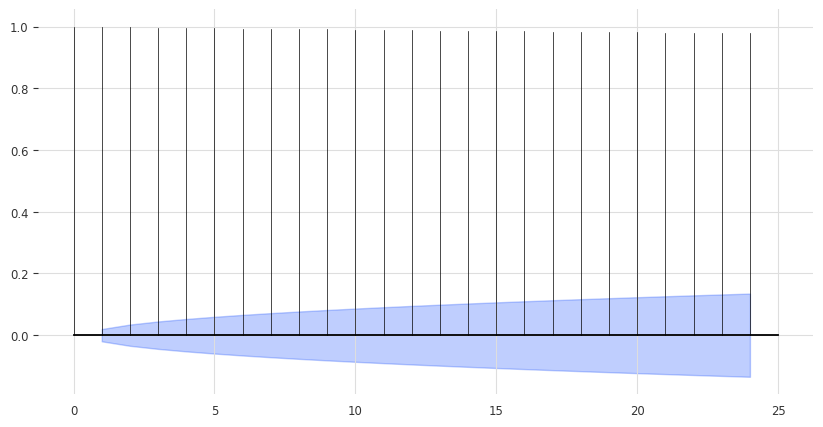

In [90]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, alpha=0.05)

Train a baseline model to benchmark against

In [91]:
from darts.models import ExponentialSmoothing


baseline_model = ExponentialSmoothing()
baseline_model.fit(train)
prediction = baseline_model.predict(len(val))

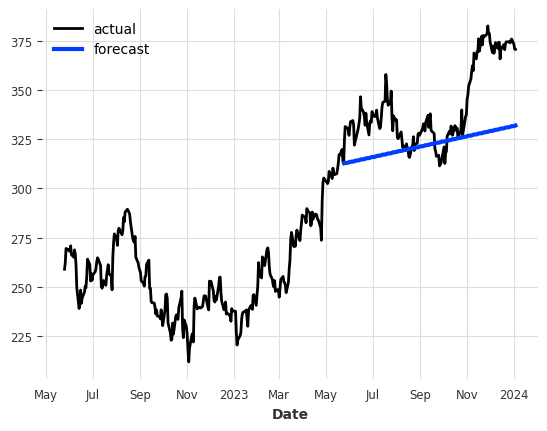

In [92]:
import matplotlib.pyplot as plt
 

actual = series.slice(pd.Timestamp('2022-05-25'), series.end_time())
actual.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

In [93]:
#from darts.models import AutoARIMA
#  
#model_aarima = AutoARIMA()
#model_aarima.fit(train)
#prediction_aarima = model_aarima.predict(len(val))

In [94]:
#import matplotlib.pyplot as plt
# 
#actual.plot(label='actual')
#prediction_aarima.plot(label='forecast', lw=3)
# plt.legend()

Train our current working model

In [95]:
#from darts.dataprocessing.transformers import Scaler
# 
#scaler = Scaler()
#train_air_scaled = scaler.fit_transform(train)
# 
#train_air_scaled.plot()
# 
encoders = {"datetime_attribute": {"past": ["month", "year"]}} # , "transformer": Scaler()}

In [96]:
train_history = 252 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 20 # model training epochs

In [97]:
from darts.models import TiDEModel

saved_model_name = 'data/canswim_model.pt'

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except RuntimeError as e:
  print('Error loading saved model:', e)
  print('Proceeding with new model')
  model = TiDEModel(
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=encoders,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
#      model_name=saved_model_name,
#      force_reset=True,
#      save_checkpoints=True,    
  )  



Loading saved model


In [98]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)

In [99]:
supports_multi_ts

True

In [100]:
# train model

model.fit(train)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | rin                 | RINorm           | 2     
4 | past_cov_projection | _ResidualBlock   | 912   
5 | encoders            | Sequential       | 339 K 
6 | decoders            | Sequential       | 189 K 
7 | temporal_decoder    | _ResidualBlock   | 594   
8 | lookback_skip       | Linear           | 10.6 K
---------------------------------------------------------
541 K     Trainable params
0         Non-trainable params
541 K     Total params
2.165     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 295/295 [00:05<00:00, 57.45it/s, train_loss=0.530] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 295/295 [00:05<00:00, 57.44it/s, train_loss=0.530]


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=252, output_chunk_length=42, add_encoders={'datetime_attribute': {'past': ['month', 'year']}}, n_epochs=20, use_reversible_instance_norm=True)

In [101]:
# save model
model.save(saved_model_name)


In [102]:
pred = model.predict(pred_horizon) # len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.14it/s]


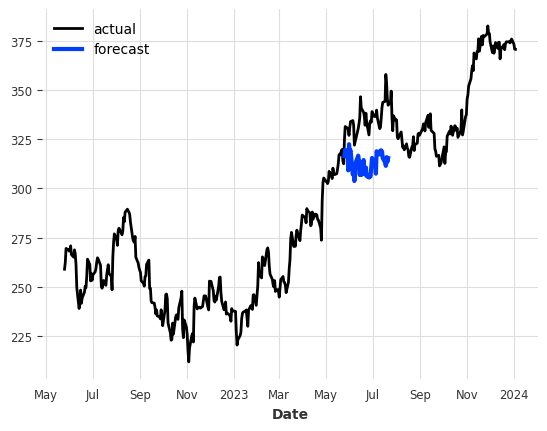

In [103]:
actual.plot(label='actual')
pred.plot(label='forecast', lw=3)
plt.legend()

Backtest Model


In [104]:

#models = [ExponentialSmoothing(),
##          NHiTSModel(input_chunk_length=6,
##            output_chunk_length=6),
#          TiDEModel(
#            input_chunk_length=24,
#            output_chunk_length=12,
#            use_reversible_instance_norm=True),
#            ]
#
#backtests = [model.historical_forecasts(series,
#                            start=.5,
#                            forecast_horizon=3)
#             for model in models]

In [105]:
# from darts.metrics import mape
#
#series.plot(label='data')
#for i, m in enumerate(models):
#    err = mape(backtests[i], series)
#    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))
#
#plt.title('Backtests with 3-months forecast horizon')
#plt.legend()